IMPORT ALL NEEDED LIBRARIES

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import os
import time

DEFINE STRUCTURAL METHODS

In [2]:
# Function to evaluate the entropy of a vector
# INPUTS
# - v: vector that contains in each cell the value of a byte (so from 0 to 255)
# - num: number of cells of the vector we want to consider in the analysis (from the first element)
# OUTPUT: entropy value
def entropy(v, num):
    freq = np.zeros(256)
    for i in range(num):
        freq[int(v[i])]=freq[int(v[i])]+1
    h = 0
    for i in range(256):
        if freq[i]>0:
            h = h + (freq[i]/num) * np.log2(freq[i]/num)
    h = -h
    return h

# Function to evaluate the entropy of a file as a function of the header lenght
# INPUTS
# - file: the file we want to anlyze (formats as an integer vector)
# - Bytes: total number of bytes we want to consider in the analysis
# OUTPUT: vector that contains the entropy values as a function of the header lenght analyzed

def entropy_analysis(file, Bytes):
    h_vector = np.zeros(int(Bytes/8)+1)
    for i in range(int(Bytes/8)+1):
        h_vector[i] = entropy(file, 8*i)
    return h_vector

# Function to evaluate the Area (DDA approach) between two files 
# INPUTS
# - h_1,h_2: vectors obtained with entropy_analysis function
# OUTPUT: value of the area
def diff_area(h_1,h_2):
    area = 0
    length = min(len(h_1),len(h_2))
    diff_vec = np.zeros(length)
    for i in range(length):
        diff_vec[i]=abs(h_1[i]-h_2[i])
    sum = 0
    for i in range(2,length-2):
        sum = sum+2*diff_vec[i]
    area = (8/2)*(diff_vec[1]+diff_vec[len(h_1)-1]+sum)
    return area

# Function to transform the file of the dataset in a vector ready to be analyzed
# INPUTS
# - file: the file from the dataset we want to analyze
# - size: the size of the file we want to cut
# OUTPUT: file vector
def file_to_vector(file, start, offset):
    vec = np.zeros(offset)
    for i in range(offset):
        vec[i] = int.from_bytes(bytes(file[start + i], 'latin-1'), byteorder="big")
    return vec

# Function that compute if the file is classified as ransomware
# INPUTS
# - treshold: value to classify the file
# - area: trapezoidal area of the file
# OUTPUT: accur (correctly classified) and err (not)
def accuracy(threshold, area):
    accur = 0.0
    #True positive
    if area <= threshold:
        accur = 1.0
    return accur

# Function that compute the differential trapezoidal area between ideal and real file
# INPUTS
# - ideal_file: file of 256 byte completely random
# - file_vector: vectorialized version of the file
# - best_hl: best header length to classify to compute the entropy, founded in best_model.ipynb
# OUTPUT: differential area between ideal and consider file
def trapezoidal_rule(ideal_file, file_vector, best_hl):
    h_ideal = entropy_analysis(ideal_file, best_hl)
    h = entropy_analysis(file_vector, best_hl)
    return diff_area(h_ideal,h)

# Function that compute the trapezoidal area of the file
# INPUTS
# - file: self explenatory
# - offset: interval of byte in which compute the area
# - best_hl: best header length to classify to compute the entropy, founded in best_model.ipynb
# - num_frams: parameter that set the different type of analysis
# OUTPUT: area of consider file
def get_areas(file, offset, best_hl, num_fragms):
    start = 0
    i = 1
    areas = []
    bound = len(file) // (len(file) // offset)
    while i <= num_fragms and len(file) >= i*offset:
        file_vector = file
        areas.append(trapezoidal_rule(ideal_file, file_vector, best_hl))
        if len(file) >= (i+1)*offset and len(file) - (i+1) * bound + offset < (i+1) * bound + offset:
            start = random.randint(i * bound, len(file) - offset)
        elif len(file) >= (i+1)*offset and i < num_fragms-1:
            start = random.randint(i * bound, (i+1) * bound)
        i+=1
    return areas

# Function that update the accuracies and error statistics
# INPUTS
# - best_tresh: best threshold for the considere analysis, computed in best_model.ipynb
# - sequences: length sequence value for which we are computing accuracy, used as and index for the acc matrix
# - jumps: jump value for which we are computing accuracy, used as and index for the acc matrix
# - acc: matrix of accuracies, also known as true positive (correctly classified ransomwares)
# - false_negatives: matrix of ransomwares incorrecly classified as safe files
# OUTPUT: void, just update the matrices acc and false_negatives
def update_statistics(best_thresh, sequences, jumps, acc, best_area):
    result = accuracy(best_thresh, best_area)
    acc[sequences][jumps] = np.add(acc[sequences][jumps], result, dtype=float)

# Function that lower the entropy of a ransomware file
# INPUTS
# - length_sequence: length of the random bytes sequence to insert into the file
# - jump: distance between each injection of random bytes
# - file: file to modify
# OUTPUT: modified file with the requested length sequence and jump
def modify_file(length_sequence, jump, file):
    modified_file = []
    for i in range(0,len(file),jump):
        random_value = float(random.randint(0, 255))
        random_values = [random_value for i in range(length_sequence)]
        modified_file += list(file[i:i+jump]) + random_values
    return modified_file

GENERATE IDEAL FILE, READ FILES PATH AND INITIALYZE SEQUENCE LENGTHS AND JUMPS

In [3]:
offset = 256 #interval to analyze
ideal_file = np.random.randint(0,offset,offset) #ideal random file for comparison reason

# Obtains all paths to analyze from a .txt files
f = open('../paths/path_ransomwares.txt', 'r')
paths = f.readlines()
f.close()

sequence_start, sequence_end, sequence_step = 2,33,2 #sequence values to start, end, and step between each number
length_sequences = np.arange(sequence_start,sequence_end,sequence_step) #generate array of such values, last values is sequence_end - 1
#jump_start, jump_end, jump_step = 2,9,2 #jump values to start, end, and step between each number
#jumps = np.arange(jump_start,jump_end,jump_step) #generate array of such values, last values is jump_end - 1
power = 5 #number of elements in jumps + 1, used for plot porpuses
jumps = np.array([12,24,32,48]) #array of jump length values

## STRESS TEST FOR AVG AREA
DEFINE AVG AREA METHOD

In [4]:
# Function that get the best area between different fragments considered
# INPUTS
# - distance: parameter that allows the method to mitigate the Davies effect
# - offset: interval of byte in which compute the area
# - areas: previously computed areas from which we pick the best one
# - num_frams: parameter that set the different type of analysis
# - file: considered file
# OUTPUT: area that better perfomr for the consider analysis
def get_best_area(distance, offset, areas, num_fragms, file):
    best_area = 0
    i=2
    mean_random_area = areas[1]
    while i < num_fragms and len(file) >= (i+1)*offset:
        mean_random_area = mean_random_area + areas[i]
        i+=1
    mean_random_area = mean_random_area / (i-1)
    if areas[0] - distance < mean_random_area:
        best_area = areas[0]
    else:
        best_area = min(areas[0], mean_random_area)
    return best_area

IMPLEMENT AND TEST BEST 3F_AVG MODEL

In [5]:
files_analyzed = 0 #total files analyzed
num_fragms = 3 #type of analysis (3 for 3F, 4 for 4F)

#initialyze results matrix
acc = np.zeros([len(length_sequences), len(jumps)], dtype = float)

In [6]:
#retrieve the best threshold, distance and header length values previously computed
thresholds = np.arange(2,35,1)
distances = np.arange(24,66,3)
acc_des=np.load('../results/acc_3F_mix_avg.npy')
acc_des = acc_des.reshape(len(thresholds), len(distances), int(offset/8))

ind = np.unravel_index(np.argmax(acc_des, axis=None), acc_des.shape)
best_thresh, best_dist, best_hl = thresholds[ind[0]], distances[ind[1]], 8*(ind[2]+1)

In [7]:
#Perform the analysis
start_time = time.time()

# Iterate over the different directories containing files to analyze
for j in range(len(paths)):
    # List all the files in the paths[j] directory
    files=os.listdir(paths[j][:-1])
    print("Start analysizng the directory", paths[j][:-1])
    # Iterate over the different files in the directory paths[j]
    for object in files:
        full_path = paths[j][:-1] + "/" + object
        f=open(full_path, "r", encoding='latin-1')
        file = f.read()
        file = file_to_vector(file,0,len(file))
        for len_seq in range(len(length_sequences)):
            for jump in range(len(jumps)):
                modified_file = modify_file(length_sequences[len_seq],jumps[jump],file)
                if len(modified_file) >= 2*offset:
                    areas = get_areas(modified_file, offset, best_hl, num_fragms)
                    best_area = get_best_area(best_dist, offset, areas, num_fragms, modified_file)
                    update_statistics(best_thresh, len_seq,jump, acc, best_area)
                files_analyzed += 1
        f.close()

acc = np.multiply(np.true_divide(acc, float(files_analyzed/(len(length_sequences)*len(jumps)))), 100.0, dtype=float)

time_spent = time.time() - start_time
print("Time for the analysis of the dataset")
print("--- %s minutes, %s seconds, %s files analyzed ---" % (time_spent//60, ((time_spent)-60*((time_spent)//60))//1, files_analyzed))

Start analysizng the directory ./NapierOneDataset/EXTRA/RANSOMWARE-MAZE-tiny
Start analysizng the directory ./NapierOneDataset/EXTRA/RANSOMWARE-DHARMA-tiny
Start analysizng the directory ./NapierOneDataset/EXTRA/RANSOMWARE-NETWALKER-tiny
Start analysizng the directory ./NapierOneDataset/EXTRA/RANSOMWARE-NOTPETYA-tiny
Start analysizng the directory ./NapierOneDataset/EXTRA/RANSOMWARE-PHOBOS-tiny
Start analysizng the directory ./NapierOneDataset/EXTRA/RANSOMWARE-RYUK-tiny
Start analysizng the directory ./NapierOneDataset/EXTRA/RANSOMWARE-SODINOKIBI-tiny
Start analysizng the directory ./NapierOneDataset/EXTRA/Wannacry-tiny
Start analysizng the directory ./NapierOneDataset/EXTRA/BadRabbit-tiny
Time for the analysis of the dataset
--- 17.0 minutes, 20.0 seconds, 8640 files analyzed ---


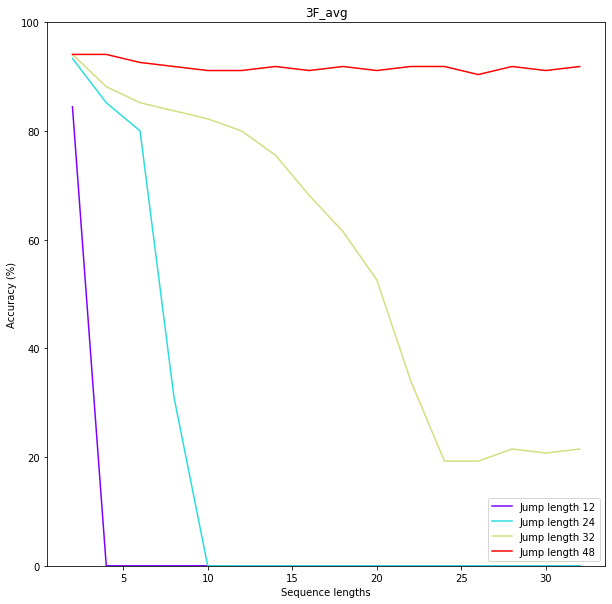

In [8]:
#plot the results
acc = np.transpose(acc) #transpose for graphical reasons

#n = round(jump_end/jump_step) #number of curves to plot = number of jumps
n = power - 1 #number of curves to plot = number of jumps
color = cm.rainbow(np.linspace(0,1,n))
plt.figure(figsize=(10,10))
plt.title("3F_avg")
plt.xlabel("Sequence lengths")
plt.ylabel("Accuracy (%)")
for i,c in zip(range(n),color):
    label = "Jump length " + str(jumps[i])
    plt.plot(length_sequences, acc[i], c=c, label=label)
plt.legend()
plt.ylim([0, 100])
plt.show()

In [9]:
#save results in a file
np.savetxt('accuracies_3F_avg_4.txt',acc)

IMPLEMENT AND TEST BEST 4F_AVG MODEL

In [10]:
files_analyzed = 0 #total files analyzed
num_fragms = 4 #type of analysis (3 for 3F, 4 for 4F)

#initialyze results matrix
acc = np.zeros([len(length_sequences), len(jumps)], dtype = float)

In [11]:
#retrieve the best threshold, distance and header length values previously computed
thresholds = np.arange(2,35,1)
distances = np.arange(33,66,3)
acc_des=np.load('../results/acc_4F_mix_avg.npy')
acc_des = acc_des.reshape(len(thresholds), len(distances), int(offset/8))

ind = np.unravel_index(np.argmax(acc_des, axis=None), acc_des.shape)
best_thresh, best_dist, best_hl = thresholds[ind[0]], distances[ind[1]], 8*(ind[2]+1)

In [12]:
#Perform the analysis
start_time = time.time()

# Iterate over the different directories containing files to analyze
for j in range(len(paths)):
    # List all the files in the paths[j] directory
    files=os.listdir(paths[j][:-1])
    print("Start analysizng the directory", paths[j][:-1])
    # Iterate over the different files in the directory paths[j]
    for object in files:
        full_path = paths[j][:-1] + "/" + object
        f=open(full_path, "r", encoding='latin-1')
        file = f.read()
        file = file_to_vector(file,0,len(file))
        for len_seq in range(len(length_sequences)):
            for jump in range(len(jumps)):
                modified_file = modify_file(length_sequences[len_seq],jumps[jump],file)
                if len(modified_file) >= 2*offset:
                    areas = get_areas(modified_file, offset, best_hl, num_fragms)
                    best_area = get_best_area(best_dist, offset, areas, num_fragms, modified_file)
                    update_statistics(best_thresh, len_seq,jump, acc, best_area)
                files_analyzed += 1
        f.close()

acc = np.multiply(np.true_divide(acc, float(files_analyzed/(len(length_sequences)*len(jumps)))), 100.0, dtype=float)

time_spent = time.time() - start_time
print("Time for the analysis of the dataset")
print("--- %s minutes, %s seconds, %s files analyzed ---" % (time_spent//60, ((time_spent)-60*((time_spent)//60))//1, files_analyzed))

Start analysizng the directory ./NapierOneDataset/EXTRA/RANSOMWARE-MAZE-tiny
Start analysizng the directory ./NapierOneDataset/EXTRA/RANSOMWARE-DHARMA-tiny
Start analysizng the directory ./NapierOneDataset/EXTRA/RANSOMWARE-NETWALKER-tiny
Start analysizng the directory ./NapierOneDataset/EXTRA/RANSOMWARE-NOTPETYA-tiny
Start analysizng the directory ./NapierOneDataset/EXTRA/RANSOMWARE-PHOBOS-tiny
Start analysizng the directory ./NapierOneDataset/EXTRA/RANSOMWARE-RYUK-tiny
Start analysizng the directory ./NapierOneDataset/EXTRA/RANSOMWARE-SODINOKIBI-tiny
Start analysizng the directory ./NapierOneDataset/EXTRA/Wannacry-tiny
Start analysizng the directory ./NapierOneDataset/EXTRA/BadRabbit-tiny
Time for the analysis of the dataset
--- 17.0 minutes, 36.0 seconds, 8640 files analyzed ---


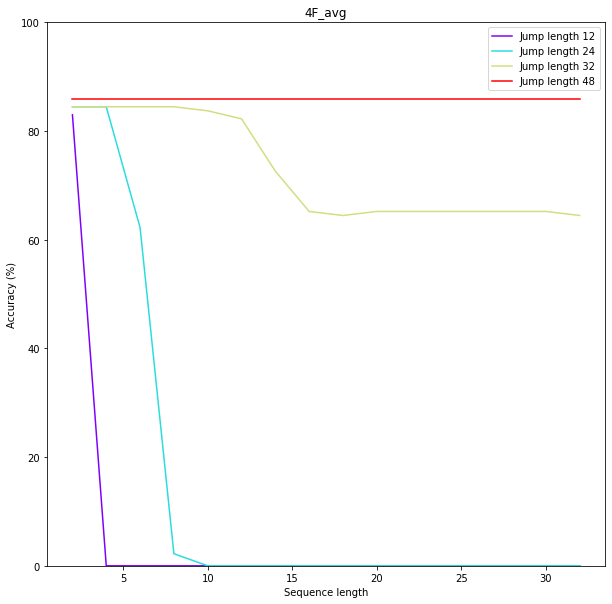

In [13]:
#plot the results
acc = np.transpose(acc) #transpose for graphical reasons

#n = round(jump_end/jump_step) #number of curves to plot = number of jumps
n = power - 1 #number of curves to plot = number of jumps
color = cm.rainbow(np.linspace(0,1,n))
plt.figure(figsize=(10,10))
plt.title("4F_avg")
plt.xlabel("Sequence length")
plt.ylabel("Accuracy (%)")
for i,c in zip(range(n),color):
    label = "Jump length " + str(jumps[i])
    plt.plot(length_sequences, acc[i], c=c, label=label)
plt.legend()
plt.ylim([0, 100])
plt.show()

In [14]:
#save results in a file
np.savetxt('accuracies_4F_avg_4.txt',acc)

## STRESS TEST FOR MAX AREA
DEFINE MAX AREA METHOD

In [15]:
# Function that get the best area between different fragments considered
# INPUTS
# - distance: parameter that allows the method to mitigate the Davies effect
# - offset: interval of byte in which compute the area
# - areas: previously computed areas from which we pick the best one
# - num_frams: parameter that set the different type of analysis
# - file: considered file
# OUTPUT: area that better perfomr for the consider analysis
def get_best_area(distance, offset, areas, num_fragms, file):
    best_area = 0
    i=2
    rand_Fs_best_area = areas[1]
    while i < num_fragms and len(file) >= (i+1)*offset:
        rand_Fs_best_area = max(areas[i-1], areas[i])
        i+=1
    if areas[0] - distance < rand_Fs_best_area:
        best_area = areas[0]
    else:
        best_area = min(areas[0], rand_Fs_best_area)
    return best_area

IMPLEMENT AND TEST BEST 3F_MAX MODEL

In [16]:
files_analyzed = 0 #total files analyzed
num_fragms = 3 #type of analysis (3 for 3F, 4 for 4F)

#initialyze results matrix
acc = np.zeros([len(length_sequences), len(jumps)], dtype = float)

In [17]:
#retrieve the best threshold, distance and header length values previously computed
thresholds = np.arange(2,35,1)
distances = np.arange(24,51,3)
acc_des=np.load('../results/acc_3F_mix.npy')
acc_des = acc_des.reshape(len(thresholds), len(distances), int(offset/8))

ind = np.unravel_index(np.argmax(acc_des, axis=None), acc_des.shape)
best_thresh, best_dist, best_hl = thresholds[ind[0]], distances[ind[1]], 8*(ind[2]+1)

In [18]:
#Perform the analysis
start_time = time.time()

# Iterate over the different directories containing files to analyze
for j in range(len(paths)):
    # List all the files in the paths[j] directory
    files=os.listdir(paths[j][:-1])
    print("Start analysizng the directory", paths[j][:-1])
    # Iterate over the different files in the directory paths[j]
    for object in files:
        full_path = paths[j][:-1] + "/" + object
        f=open(full_path, "r", encoding='latin-1')
        file = f.read()
        file = file_to_vector(file,0,len(file))
        for len_seq in range(len(length_sequences)):
            for jump in range(len(jumps)):
                modified_file = modify_file(length_sequences[len_seq],jumps[jump],file)
                if len(modified_file) >= 2*offset:
                    areas = get_areas(modified_file, offset, best_hl, num_fragms)
                    best_area = get_best_area(best_dist, offset, areas, num_fragms, modified_file)
                    update_statistics(best_thresh, len_seq,jump, acc, best_area)
                files_analyzed += 1
        f.close()

acc = np.multiply(np.true_divide(acc, float(files_analyzed/(len(length_sequences)*len(jumps)))), 100.0, dtype=float)

time_spent = time.time() - start_time
print("Time for the analysis of the dataset")
print("--- %s minutes, %s seconds, %s files analyzed ---" % (time_spent//60, ((time_spent)-60*((time_spent)//60))//1, files_analyzed))

Start analysizng the directory ./NapierOneDataset/EXTRA/RANSOMWARE-MAZE-tiny
Start analysizng the directory ./NapierOneDataset/EXTRA/RANSOMWARE-DHARMA-tiny
Start analysizng the directory ./NapierOneDataset/EXTRA/RANSOMWARE-NETWALKER-tiny
Start analysizng the directory ./NapierOneDataset/EXTRA/RANSOMWARE-NOTPETYA-tiny
Start analysizng the directory ./NapierOneDataset/EXTRA/RANSOMWARE-PHOBOS-tiny
Start analysizng the directory ./NapierOneDataset/EXTRA/RANSOMWARE-RYUK-tiny
Start analysizng the directory ./NapierOneDataset/EXTRA/RANSOMWARE-SODINOKIBI-tiny
Start analysizng the directory ./NapierOneDataset/EXTRA/Wannacry-tiny
Start analysizng the directory ./NapierOneDataset/EXTRA/BadRabbit-tiny
Time for the analysis of the dataset
--- 17.0 minutes, 24.0 seconds, 8640 files analyzed ---


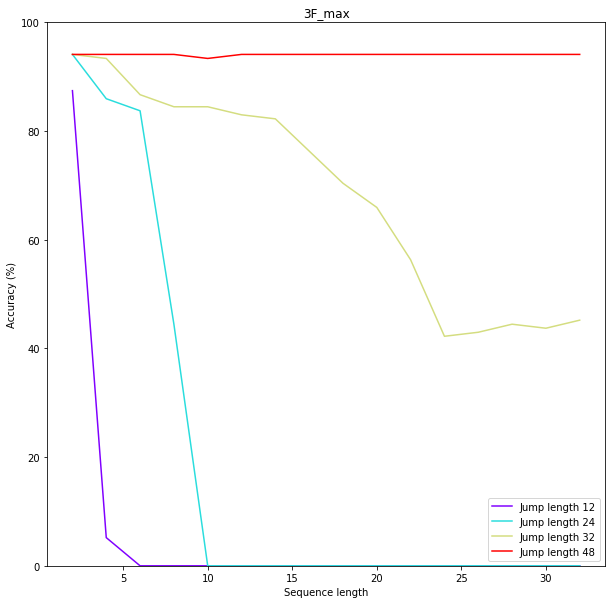

In [19]:
#plot the results
acc = np.transpose(acc) #transpose for graphical reasons

#n = round(jump_end/jump_step) #number of curves to plot = number of jumps
n = power - 1 #number of curves to plot = number of jumps
color = cm.rainbow(np.linspace(0,1,n))
plt.figure(figsize=(10,10))
plt.title("3F_max")
plt.xlabel("Sequence length")
plt.ylabel("Accuracy (%)")
for i,c in zip(range(n),color):
    label = "Jump length " + str(jumps[i])
    plt.plot(length_sequences, acc[i], c=c, label=label)
plt.legend()
plt.ylim([0, 100])
plt.show()

In [20]:
#save results in a file
np.savetxt('accuracies_3F_max_4.txt',acc)

IMPLEMENT AND TEST BEST 4F_MAX MODEL

In [21]:
files_analyzed = 0 #total files analyzed
num_fragms = 4 #type of analysis (3 for 3F, 4 for 4F)

#initialyze results matrices
acc = np.zeros([len(length_sequences), len(jumps)], dtype = float)

In [22]:
#retrieve the best threshold, distance and header length values previously computed
thresholds = np.arange(2,35,1)
distances = np.arange(27,60,3)
acc_des=np.load('../results/acc_4F_mix.npy')
acc_des = acc_des.reshape(len(thresholds), len(distances), int(offset/8))

ind = np.unravel_index(np.argmax(acc_des, axis=None), acc_des.shape)
best_thresh, best_dist, best_hl = thresholds[ind[0]], distances[ind[1]], 8*(ind[2]+1)

In [23]:
#Perform the analysis
start_time = time.time()

# Iterate over the different directories containing files to analyze
for j in range(len(paths)):
    # List all the files in the paths[j] directory
    files=os.listdir(paths[j][:-1])
    print("Start analysizng the directory", paths[j][:-1])
    # Iterate over the different files in the directory paths[j]
    for object in files:
        full_path = paths[j][:-1] + "/" + object
        f=open(full_path, "r", encoding='latin-1')
        file = f.read()
        file = file_to_vector(file,0,len(file))
        for len_seq in range(len(length_sequences)):
            for jump in range(len(jumps)):
                modified_file = modify_file(length_sequences[len_seq],jumps[jump],file)
                if len(modified_file) >= 2*offset:
                    areas = get_areas(modified_file, offset, best_hl, num_fragms)
                    best_area = get_best_area(best_dist, offset, areas, num_fragms, modified_file)
                    update_statistics(best_thresh, len_seq,jump, acc, best_area)
                files_analyzed += 1
        f.close()

acc = np.multiply(np.true_divide(acc, float(files_analyzed/(len(length_sequences)*len(jumps)))), 100.0, dtype=float)

time_spent = time.time() - start_time
print("Time for the analysis of the dataset")
print("--- %s minutes, %s seconds, %s files analyzed ---" % (time_spent//60, ((time_spent)-60*((time_spent)//60))//1, files_analyzed))

Start analysizng the directory ./NapierOneDataset/EXTRA/RANSOMWARE-MAZE-tiny
Start analysizng the directory ./NapierOneDataset/EXTRA/RANSOMWARE-DHARMA-tiny
Start analysizng the directory ./NapierOneDataset/EXTRA/RANSOMWARE-NETWALKER-tiny
Start analysizng the directory ./NapierOneDataset/EXTRA/RANSOMWARE-NOTPETYA-tiny
Start analysizng the directory ./NapierOneDataset/EXTRA/RANSOMWARE-PHOBOS-tiny
Start analysizng the directory ./NapierOneDataset/EXTRA/RANSOMWARE-RYUK-tiny
Start analysizng the directory ./NapierOneDataset/EXTRA/RANSOMWARE-SODINOKIBI-tiny
Start analysizng the directory ./NapierOneDataset/EXTRA/Wannacry-tiny
Start analysizng the directory ./NapierOneDataset/EXTRA/BadRabbit-tiny
Time for the analysis of the dataset
--- 17.0 minutes, 29.0 seconds, 8640 files analyzed ---


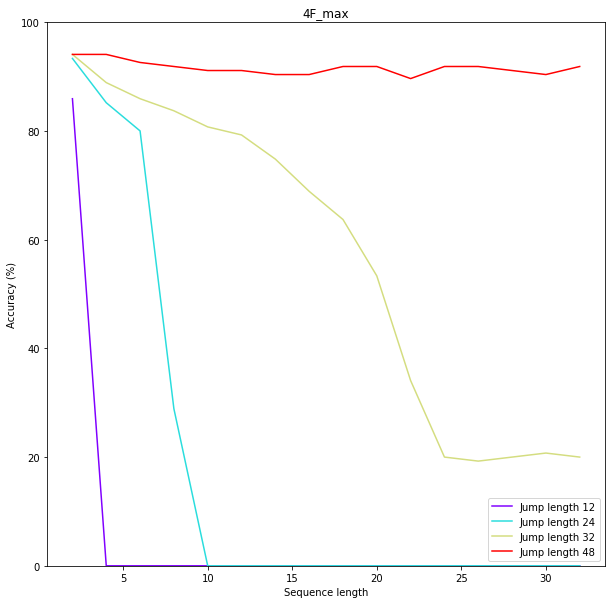

In [24]:
#plot the results
acc = np.transpose(acc) #transpose for graphical reasons

#n = round(jump_end/jump_step) #number of curves to plot = number of jumps
n = power - 1 #number of curves to plot = number of jumps
color = cm.rainbow(np.linspace(0,1,n))
plt.figure(figsize=(10,10))
plt.title("4F_max")
plt.xlabel("Sequence length")
plt.ylabel("Accuracy (%)")
for i,c in zip(range(n),color):
    label = "Jump length " + str(jumps[i])
    plt.plot(length_sequences, acc[i], c=c, label=label)
plt.legend()
plt.ylim([0, 100])
plt.show()

In [25]:
#save results in a file
np.savetxt('accuracies_4F_max_4.txt',acc)